<a href="https://colab.research.google.com/github/ricardofradeb/analise_dados_spotify/blob/main/Trabalho1_RicardoFrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primeiro Trabalho de Ciência de Dados - Deadline  

Nome: Ricardo Frade Brandão  
Matrícula: 164450006  
Curso: Engenharia Mecatrônica

#Análise de Dados de um Dataset Retirado da API do Spotify

Este trabalho tem como base dois artigos principais, sendo um desses o da [Sandra](https://datascientistdiary.com/index.php/2021/03/04/how-to-use-spotify-api-and-what-data-science-opportunities-can-it-open-up/) postado no *Data Scientist Diary* e do [Nik Linnane](https://medium.com/mlearning-ai/spotify-playlists-data-science-69b05e628bb9) postado no *Medium*.
Também utiliza-se de referência secundária o artigo do [Adam Reevesman](https://towardsdatascience.com/spotify-wrapped-data-visualization-and-machine-learning-on-your-top-songs-1d3f837a9b27) postado no *Toward Data Science*.

Utiliza-se o dataset disponibilizado no [Github](https://gist.github.com/samshadwell/74421960c4dd4bf0fe153efdb4c869e4) pelo usuário [Sam Shadwell](https://gist.github.com/samshadwell), que tem os dados de um usuário retirados a partir da API do Spotify. Tem-se como referência esse dataset pois o mesmo nos dá informações que podem ser utilizadas para a implementação de um sistema de recomendação.

In [ ]:
# Importação das bibliotecas a ser utilizadas:

from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import seaborn as sns
import warnings
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [ ]:
# Importação do DataFrame apartir do arquivo .csv contigo no Google Drive:

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Dados/spotify_data.csv',sep=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Comando utilizado para o dataset de forma simplificada:

df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,0.243818,0.632979,233489.524242,0.594547,0.063733,5.245455,0.185985,-7.421961,0.530303,0.110673,121.855400,3.960606,0.421082
std,0.252326,0.142459,65546.807323,0.182206,0.182574,3.608129,0.153581,2.827279,0.499839,0.112791,26.572325,0.294261,0.225783
min,0.000087,0.201000,66786.000000,0.045900,0.000000,0.000000,0.030500,-23.387000,0.000000,0.023800,67.413000,1.000000,0.035100
25%,0.031525,0.543250,196918.000000,0.478500,0.000000,1.250000,0.096100,-8.418750,0.000000,0.040900,100.992500,4.000000,0.231250
50%,0.157500,0.642500,226376.500000,0.591000,0.000031,6.000000,0.125500,-7.053500,1.000000,0.061000,123.076500,4.000000,0.401000
75%,0.394250,0.737500,257587.500000,0.728750,0.006605,8.000000,0.214500,-5.578500,1.000000,0.134250,141.543250,4.000000,0.585500
max,0.985000,0.958000,690973.000000,0.951000,0.926000,11.000000,0.902000,-2.492000,1.000000,0.685000,200.813000,5.000000,0.975000


#Features

Todas as *features* da base de dados foram fornecidas pela API do Spotify e na sua documentação é possível entender o que cada parâmetero significa.

*   **Acousticness**: Uma medida de confiança que varia de 0.0 a 1.0 que define se uma faixa é acustica ou não, onde 1.0 representa uma alta confiança que a faixa é acústica;
*   **Danceability**: Classifica se uma faixa é ou não adequada para dançar, ela é baseada em uma combinação de alguns elementos músicais, como o tempo, estabilidade do ritmo, instensidade da batida e outras informações gerais. O valor 1.0 indica que a música é muito indicada para ser dançada, enquanto o número 0.0 indica o oposto;
*   **Duration_ms**: O tempo de duração da faixa em milisegundos;
*   **Energy**: Energia é medida de 0.0 a 1.0 e representa e indica uma medida perceptual de intensidade e atividade. Faixas energéticas costumam ser rápidas e barulhentas. O valor 1.0 indica que a música é mais agitada e "enérgica" eu comparação as mais, como por exemplo podemos citar o heavy metal, porém quanto mais o valor de aproxima de o valor 0.0 poemos dizer que a múcia é mais "calma";
*   **Instrumentalness**: Parecida com a acousticness, esse valor que também varia de 0.0 a 1.0 indica se a música é instrumental, ou seja, sem vocal. As faixas acima de 0.5 já são consideradas instrumentais, porém quanto maior esse valor maior a confiança nessa informação;
*   **Liveness**: Detecta a presença de público nas faixas, feito para identificar gravações ao vivo. Acima de 0.8 a faixa já é considerada ao vivo;
*   **Loudness**: Volume total da música em decibeis (dB). Os valores são relatados durante toda a faixa, e ele é útil para comparar a intensividade relativa da faixa;
*   **Mode**: Valor inteiro que indica a modalidade do som, o tipo de escala da qual o conteúdo da melodia é entregue;
*   **Speechiness**: Valor que indica a presença de partes faladas dentro da faixa. Podcasts, Talk Shows, Audiobooks, etc., tem valores mais próximos de 1.0, valores entre 0.33 e 0.66 são consideradas músicas que contém falas no seu conteúdo, como por exemplo raps. Por fim, valores abaixo de 0.33 representam músicas e faixas que não estão relacionadas a falas;
*   **Tempo**: O tempo total da música estimado em batidas por minuto. O tempo é considerado como a velocidadeou ritmo de uma determinada peça e deriva diretamente da duração média da batida;
*   **Valence**: Valor que varia de 0.0 a 1.0 descrevendo a positividade musical transmitida por uma faixa. Faixas próximas a 1.0 são consideradas alegres e positivas e faixas próximas a 0.0 são consideradas depressivas e tristes.

Então, será criado um painel que contém as features Acousticness, Danceability, Energy e Instrumentalness para que se possa fazer a distribuição dos dados em um gráfico de dispersão.

In [ ]:
# Função para plotagem dos gráficos de dispersão:

def plotarDispersoes(axis,features,colors, titles):
    fig, (axis) = plt.subplots(ncols=len(axis), figsize=(20, 5))   
    qtd_itens = len(axis)
    i = 0
    while i < qtd_itens:
        axis[i].hist(df[features[i]], 10, density=True, histtype='stepfilled', facecolor=colors[i], alpha=0.75)
        axis[i].set_title(titles[i])
        i+=1
    fig.tight_layout()
    plt.show()

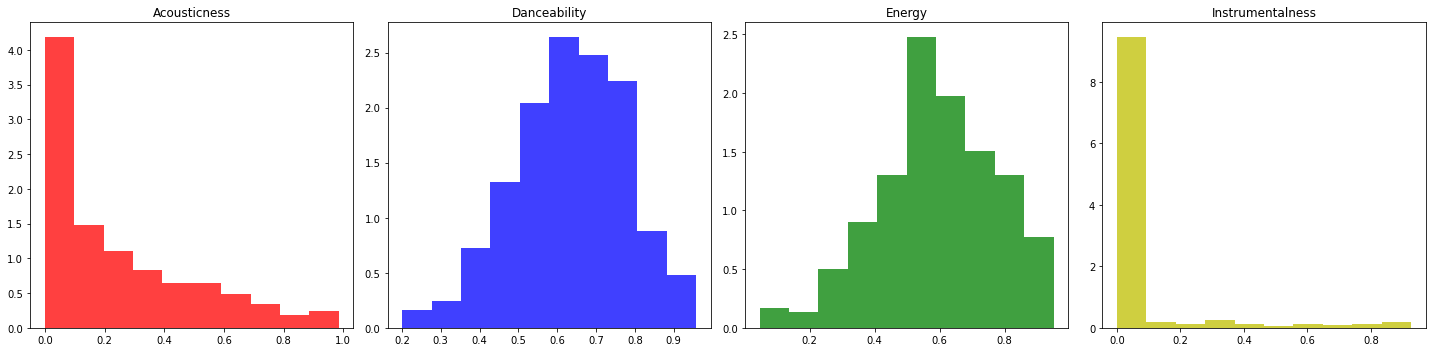

In [ ]:
# Plotar os primeiros de gráficos de dispersão:

axis = ['ax0','ax1','ax2','ax3']
features = ['acousticness', 'danceability', 'energy', 'instrumentalness']
colors = ['r', 'b','g', 'y']
titles = ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness']
plotarDispersoes(axis,features,colors,titles)

#Correlatividade entre as features

Duas features tem um determinado grau de correlatividade entre elas que é originado de acordo com a alteração do valor de uma, gerando alteração na outra.
Esse grau é definido na tabela abaixo:  

|Grau de correlação |Descrição|
|--|--|
|x>=0.9| Muito forte|  
|0.9 > x >= 0.7| Forte|  
|0.7 > x >= 0.5| Moderada|  
|0.5 > x | Baixa|   

In [ ]:
# Mostrar a correlação dos dados:

df.corr() 

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
acousticness,1.000000,-0.056309,-0.094181,-0.533682,-0.019406,-0.006110,-0.020834,-0.541935,0.075184,0.256027,-0.181830,-0.067851,0.030164
danceability,-0.056309,1.000000,-0.209540,-0.038095,-0.042097,-0.003319,-0.038836,0.055240,-0.040052,0.090145,-0.184231,0.024052,0.316583
duration_ms,-0.094181,-0.209540,1.000000,0.030080,0.065836,0.028050,-0.002786,0.030913,-0.002324,-0.112378,0.069343,0.115161,-0.193204
energy,-0.533682,-0.038095,0.030080,1.000000,-0.106964,0.032805,0.128632,0.738991,-0.021530,-0.037126,0.101139,0.053805,0.306317
instrumentalness,-0.019406,-0.042097,0.065836,-0.106964,1.000000,0.004102,-0.066493,-0.201866,0.061423,-0.124592,0.059530,-0.136196,-0.179924
key,-0.006110,-0.003319,0.028050,0.032805,0.004102,1.000000,0.060643,-0.002615,-0.158347,-0.040835,0.009362,-0.053847,-0.040825
liveness,-0.020834,-0.038836,-0.002786,0.128632,-0.066493,0.060643,1.000000,0.079891,-0.083177,0.121789,0.003210,-0.049379,0.076262
loudness,-0.541935,0.055240,0.030913,0.738991,-0.201866,-0.002615,0.079891,1.000000,-0.048815,-0.153065,0.136041,0.062867,0.207054
mode,0.075184,-0.040052,-0.002324,-0.021530,0.061423,-0.158347,-0.083177,-0.048815,1.000000,0.039407,0.141926,-0.126184,0.004297
speechiness,0.256027,0.090145,-0.112378,-0.037126,-0.124592,-0.040835,0.121789,-0.153065,0.039407,1.000000,-0.018848,-0.051216,0.153450


Para sintetizar os dados de forma mais intuitiva, é possível gerar um *heatmap* com as informações acima.

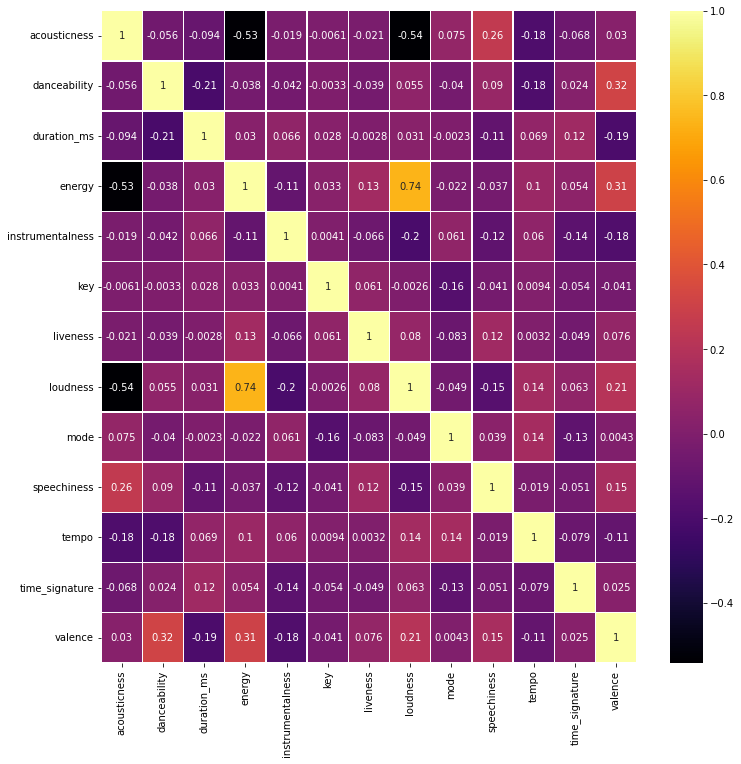

In [ ]:
# Mostrar o primeiro gráfico de mapa:

%matplotlib inline
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, linewidths=0.5, linecolor='white', cmap='inferno')
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi=500) 
plt.show()

Com uma breve análise, pode-se perceber uma **correlação** **moderada** obtida entre a feature acousticness e as features energy e loudness, assim como uma **correlação** **muito forte** entre a feature energy e a feature loudness. Também é perceptível uma **baixa correlação** da feature valence com a danceability.

In [ ]:
# Função para plotagem dos gráficos de dispersão com regressão:

def plotarDispersoesRegressao(n_linhas,n_elem,axis,features,colors, titles):
    fig, (axis) = plt.subplots(n_linhas, n_elem, figsize=(20, 5))   
    qtd_itens = len(axis)
    i = 0
    while i < qtd_itens:
        axis[i] = sns.regplot(x = df[features[i][0]], y = df[features[i][1]], data=df, color=colors[i], line_kws={'color':'black'}, ax=axis[i])
        axis[i].set_title(titles[i])
        i+=1
    plt.subplots_adjust(wspace=1)
    plt.savefig("test_rasterization.png", dpi=150) 
    plt.show()

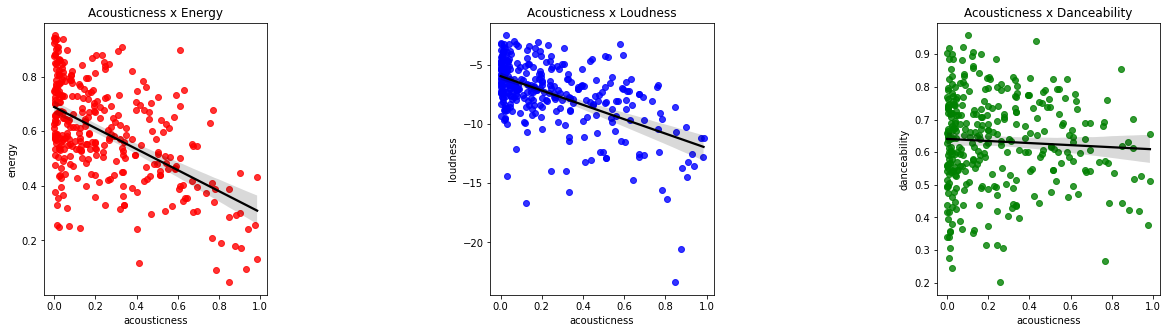

In [ ]:
# Plotar os segundos de gráficos de dispersão:

axis = ['ax0','ax1','ax2']
features = [['acousticness','energy'],['acousticness','loudness'],['acousticness','danceability']]
colors = ['r', 'b','g']
titles = ['Acousticness x Energy', 'Acousticness x Loudness', 'Acousticness x Danceability']
plotarDispersoesRegressao(1,3,axis,features,colors,titles)

É possível observar que uma menor energia, sonoridade e tendência de ser dançante tende a surgir de faixas acústicas, gerando assim uma relação negativa, podendo assim nós indicar 
Pode-se perceber que há relações negativas relevantes: As faixas com maior possibilidade de serem acústicas tem a tendência de possuir menor energia, uma menor sonoridade e menor tendência de serem dançantes

# Para os trabalhos seguintes

Com a utilização de uma base de dados retirada da API do Spotify pode-se começar a implementação de um sistema de recomendação músical *criado* a partir de um algoritimo de *Machine Learning* utilizando bibliotecas existentes renomadas na área.